# Projet d'économétrie SES722

## Cours de Patrick Waelbroeck

## Année 2021-2022

## Partie 2. Séries temporelles

### Librairie

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson 
from scipy.linalg import toeplitz

import warnings
warnings.filterwarnings("ignore")

### 1. Importer les données du fichier quarterly.xls (corriger le problème éventuel d’observations manquantes) 

In [2]:
df = pd.read_excel('quarterly.xls')
print('Les dimensions de nos données sont de %d lignes et %d colonnes.' % (df.shape[0], df.shape[1]))

Les dimensions de nos données sont de 212 lignes et 19 colonnes.


In [3]:
df.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


Regardons s'il y a des données manquantes

In [4]:
k = 0
for i in df.columns:
    if df[i].isna().sum() > 0 :k+=1
print("il y a %d valeurs manquantes" % (k))

il y a 0 valeurs manquantes


Les dimensions de notre table sont de 212 lignes pour 19 colonnes. Nous n’avons trouvé aucune donnée manquante.

### 2. Stationnariser la série de CPI en utilisant la méthode de régression qui inclue un terme de tendance dont la forme fonctionnelle est à choisir (linéaire, quadratique, log, exponentielle, …) 

Le Consumer Price Index (CPI) est l’indice des prix à la consommation. Le CPI mesure le prix d’une panier de biens et de services dans toute l’économie. <br> <br>
Il permet donc d’étudier les variations de prix d’un panier type de biens de consommation et de services achetés par les ménages.

occupons-nous du format de la colonne date. Transformons-là en Datetime

In [5]:
df['DATE'] = pd.to_datetime(df.DATE)

Regardons le graph de la série CPI en fonction de la date

Text(0.5, 1.0, 'Les valeurs du CPI en fonction du temps')

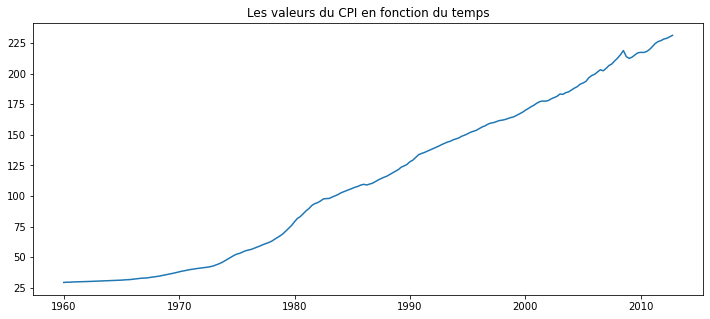

In [6]:
x = df['DATE']
y = df['CPI']
plt.figure(figsize=(12, 5))
plt.plot(x, y)
plt.title("Les valeurs du CPI en fonction du temps")

la tendance liénaire est celle qui s'approche le plus de nos données

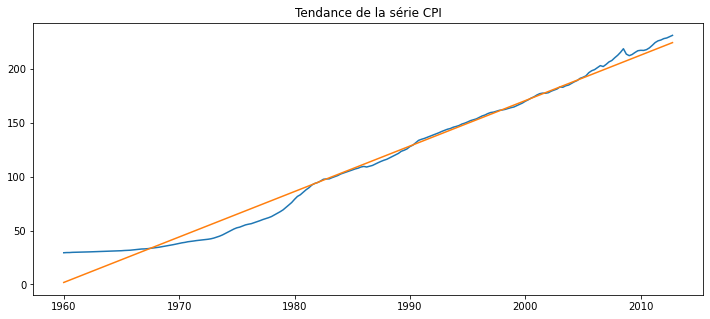

In [7]:
y = df['CPI']
l, n = list(), 0

# pour nos calculs on doit construire un X et le reshape par la suite
for i in range(df.shape[0]):
    l.append(n)
    n+=1
X = np.reshape(l, (len(l), 1))

# Régression linéaire
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

# prédiction
y_pred = lr.predict(X)

# figure
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'], y)
plt.plot(df['DATE'], y_pred)
plt.title("Tendance de la série CPI");

- La courbes bleues représentent la série de données CPI
- la courbe en orange représente la tendance

In [8]:
tend = list()
for i in range(df.shape[0]):
    tend.append(y[i] - y_pred[i])

Text(0.5, 1.0, 'Notre série CPI stationnarisé')

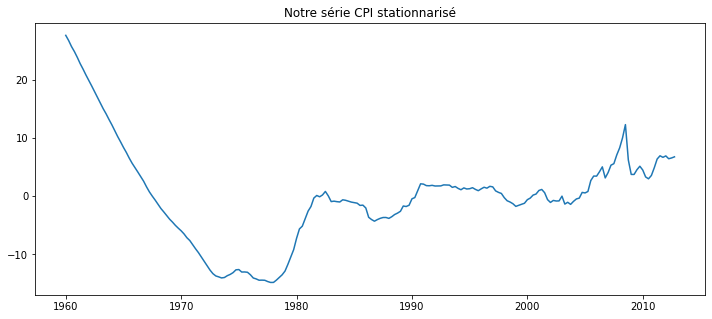

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'], tend)
plt.title("Notre série CPI stationnarisé")

Cette courbe ci-dessus représente la série une fois la tendance enlevée. On peut remarqué que notre tendance linéaire nous renvoie de mauvais résultat sur la période allant de 960 à 1980.

### 3. Stationnariser la série de CPI en utilisant un moyenne mobile centrée 5x5. 

**rolling()** : La fonction Python Pandas DataFrame.rolling() fournit une fenêtre déroulante pour les opérations mathématiques. <br>

**window** : Il s’agit d’un paramètre de type entier, décalé ou de sous-classe BaseIndexer. Il spécifie la taille de la fenêtre. Chaque fenêtre a une taille fixe. Ce paramètre spécifie le nombre d’observations utilisées pour le calcul de la statistique. Ici nous prenons $window=5$

Nous appliquons à notre série CPI une moyenne mobile centrée 5x5 pour pouvoir la stationnariser. Nous remarquons qu’avec ce processus, nous avons perdu des données : soit 4 obsevations à la fin et 4 observations au début. Nous obtenons alors : 

In [10]:
y_ = y.rolling(window=5).mean()

In [11]:
tend = y-y_

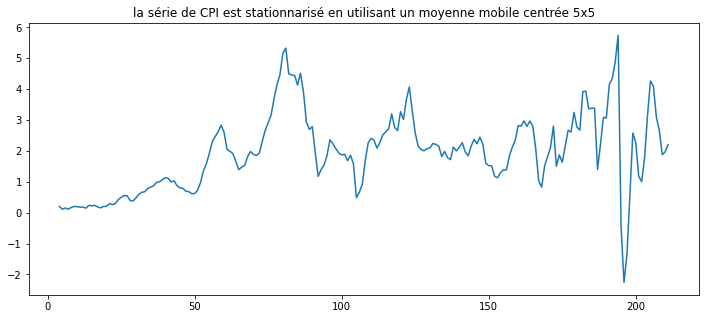

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(tend)
plt.title("la série de CPI est stationnarisé en utilisant un moyenne mobile centrée 5x5");

Au regard de la question précédente notre tendance que nous avions obtenu avec la moyenne mobile était proche de notre série d'origine. Notons l'impacte de cette tendance après lissage sur notre série, obtenu après l'avoir stationnarisé. La série que nous avons à l'origine n'a pas beaucoup de cylce au début de sa période, par ailleurs nous retrouvons peu de fluctuation sur cette période après avoir stationnarisé notre série. Mais sur les années 2007 à 2012 nous retrouvons de fortes fluctuations ; ce qui représente à une crise économie qui a eu lieu pendant cette période.

### 4. Calculer l'inflation, le taux d’inflation à partir de la variable CPI. Faire un graphique dans le temps de  inf. Commentez. 

Pour calculer le taux d’inflation à partir du CPI, on passe la variable en logarithme, puis on prend
la différence première (la différence du log étant à peu près égale au taux de croissance). On obtient
alors un taux d’inflation trimestriel, qu’on peut optionnellement multiplier par 4 pour obtenir un
taux annualisé. On retiendra ici cette option. On obtient alors :

Calculer le taux d'inflation à l'aide du CPI revient à passer notre variable à l'échelle logarithmique, Une fois cette transformation faite ; nous calculons un lag(1) avec le log(CPI) et nous faisons la différence première. Nous obtenons un taux d'inflation pour chaque trismestre ; nous pouvons multiplier ce taux par 4 pour avoir un taux annuel. Nous avons donc : 

**Première méthode :**

La dataframe.pct_change() fonction Pandas calcule le pourcentage de changement entre l’élément actuel et un élément précédent. Cette fonction calcule par défaut le pourcentage de changement par rapport à la ligne immédiatement précédente. <br> <br>
En ordonné de notre courbe nous retrouvons le taux d'inflation et en abscisse le temps.

In [13]:
df['inflation'] = df['CPI'].pct_change().dropna()*400

Text(0.5, 1.0, 'taux d’inflation à partir de la variable CPI au cours du temsp')

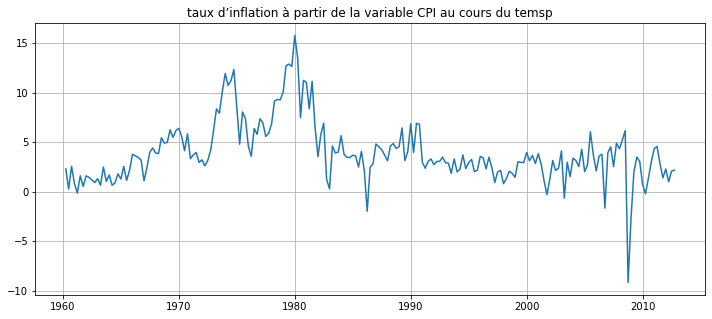

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'], df['inflation'])
plt.grid()
plt.title("taux d’inflation à partir de la variable CPI au cours du temsp")

**Deuxième méthode :**

In [15]:
cpi = df['CPI'].tolist()
n = list()
for i in range(1, len(cpi)) :
    n.append((np.log(cpi[i]) - np.log(cpi[i-1]))*400)

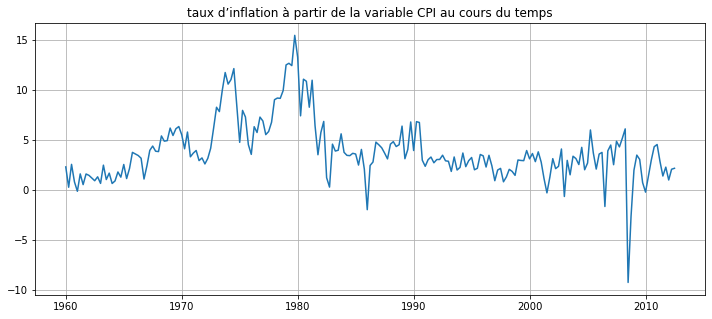

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'].tolist()[:-1], n)
plt.grid()
plt.title("taux d’inflation à partir de la variable CPI au cours du temps");

Nous pouvons observer que l'inflation à fortement varié au cours du temps et ces variations sont différentes selon les périodes. Ces fluctuations du taux d'inflation sont notamment dû aux événements économiques qui ont lieu au cours de différentes périodes : les chocs pétroliers de 1973 ou encore la crise des subprimes en 2008. Nous pouvons trouver facilement sur internet des liste de crises économiques qui ont eut lieu depuis les années 1970 : 

https://cryptophilo.fr/2017/01/04/principales-etapes-de-la-crise-economique/

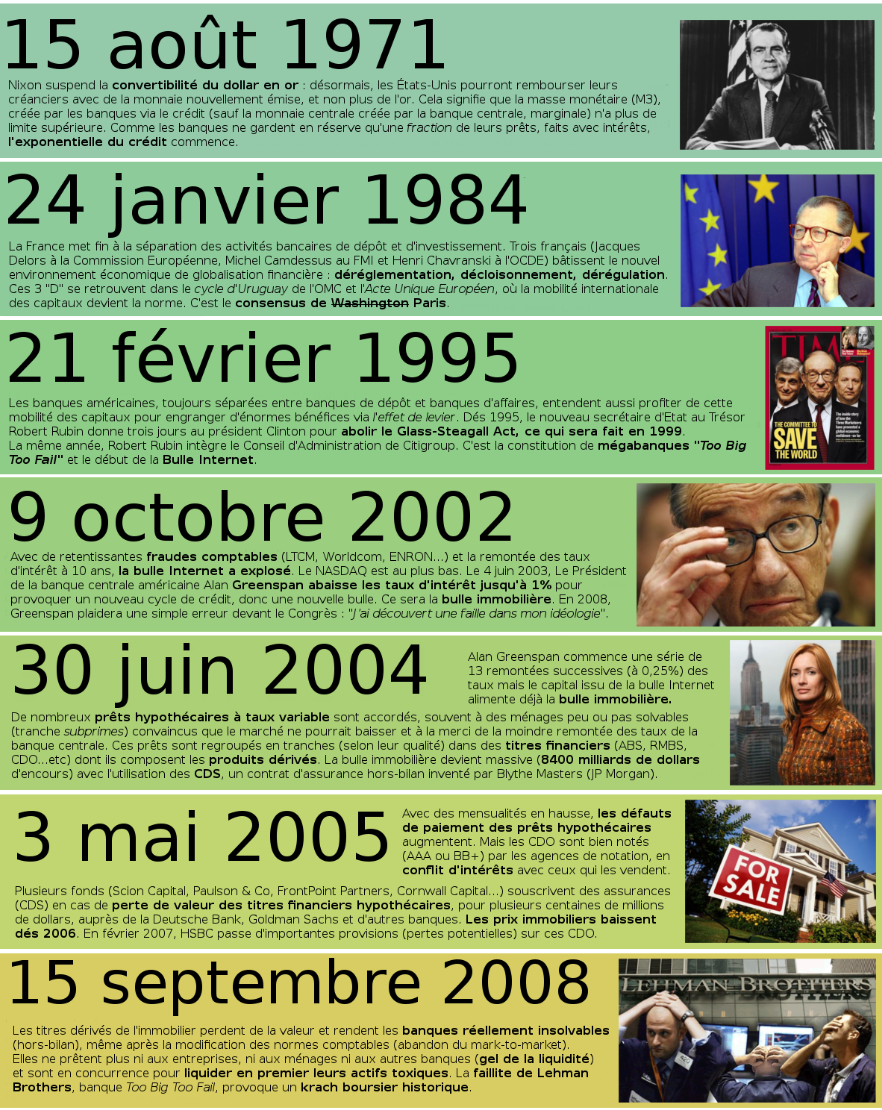

### 5. Interpréter l'autocorrélogramme et l'autocorrélogrammes partiels de inf. Quelle est la différence entre ces deux graphiques ? 


Graphiques des fonctions d’autocorrélation et d’autocorrélation partielles de la série Inflation :

On supprime les valeurs manquantes de notre nouvelle variable **inflation** pour éviter des problèmes quand nous créerons nos graphiques 

In [17]:
data = df['inflation'].dropna()

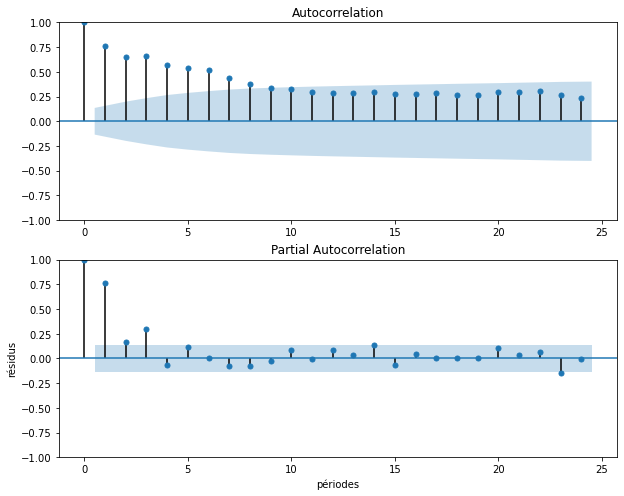

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))
fig = sm.graphics.tsa.plot_acf(data, ax=axes[0])
plt.ylabel('résidus')
plt.xlabel("périodes")
fig = sm.graphics.tsa.plot_pacf(data, ax=axes[1])

La fonction d’autocorrélation (ACF) est une mesure de la corrélation entre les observations d’une série chronologique qui sont séparées par des unités de temps k. En somme l'ACF nous indique la corrélation brute qui peut exister dans notre série entre le temps $t$ et le temps $t+1$ . Utilisons la fonction d’autocorrélation et les fonctions d’autocorrélation partielle pour identifier les modèles ARIMA. Examinons les pointes à chaque décalage pour déterminer si elles sont significatives. Un pic important dépassera les limites de signification, ce qui indique que la corrélation pour ce décalage n’est pas égale à zéro. Cette fonction joue un rôle important dans l’analyse des données visant à déterminer l’ampleur du lag dans un modèle autorégressif. L’utilisation de cette fonction a été introduite dans le cadre de l’approche Box–Jenkins de la modélisation des séries chronologiques, dans le cadre de laquelle le tracé des fonctions autocorrélatrices partielles permet de déterminer les décalages p appropriés dans un modèle AR (p) ou dans un modèle ARIMA étendu (p,d,q).

Dans l’analyse des times series, la fonction d’autocorrélation partielle (PACF) donne la corrélation partielle d’une série chronologique stationnaire avec ses propres valeurs décalées, diminuée des valeurs de la série chronologique à tous les décalages plus courts. Il contraste avec la fonction d’autocorrélation, qui ne contrôle pas les autres décalages. La PCAF va nous indiqué s'il existe dans une time serie des corrélations entre la temps $t$ et le temps $t+h$ quand nous avons supprimer les effet des corrélation de nos périodes $t+1$ , ..., $t+h-1$ ; nous obtenons les coéfficient d'une regression linéaire multiple.

- L’autocorrélogramme indique que l’autocorrelation diminue avec le temps comme dans un processus ARMA(p,q)
- L’autocorrélogramme partiel oscille autour de 0 comme dans un processus de type Moving Average MA(1)
Cela signifie notamment qu’il existe une influence non-négligeable du passé pour la détermination des valeurs présentes. On peut supposer que la série n’est pas stationnaire.

### 6. Quelle est la différence entre la stationnarité et l'ergodicité ? Pourquoi a-t-on besoin de ces deux conditions. Expliquez le terme "spurious regression".

**La stationnarité** fait référence aux distributions des variables aléatoires. Plus précisément, dans un processus stationnaire, toutes les variables aléatoires ont la même fonction de distribution, et plus généralement, pour chaque entier positif $n$ et $n$ moment $t_1, ..., t_n$ la distribution conjointe des $n$ variables aléatoires $X(t_1), ... , X(t_n)$ est la même que la distribution conjointe de $X(t_1 + \tau), ..., X(t_n + \tau)$. C’est-à-dire, si on décale tous les instants de temps par $\tau$, la description statistique du processus ne change pas du tout : le processus est stationnaire.

**L'ergodicité**, quant à elle, ne s'intéresse pas aux propriétés statistiques des variables aléatoires mais aux trajectoires de l'échantillon (sample path), c'est-à-dire à ce que l'on observe physiquement. Pour en revenir aux variables aléatoires, rappellons-nous que ces variables aléatoires sont des correspondances entre un échantillon et des nombres réels; ainsi différentes variables aléatoires mappent généralement un résultat donné à des nombres différents. <br>
Par exemple : soit une expérience qui a abouti à un résultat $\omega$ dans l'espace de l'échantillon et ce résultat a été mappé sur des nombres réels (typiquement différent) par toutes les variables aléatoires dans le processus : Plus précisément, la variable aléatoire $X(t)$ a mappé $\omega$ avec un nombre réel que nous appellerons $x(t)$. Les nombres x(t), considérés comme une forme d'onde, sont le chemin d'échantillon (sample path) correspondant à $\omega$, et différents résultats nous donneront des chemins d'échantillon (sample path) differents. L’ergodicité traite ensuite des propriétés des chemins d’échantillonnage (sample path) et de la façon dont ces propriétés se rapportent aux propriétés des variables aléatoires composant le processus aléatoire.

**un processus ergodique stationnaire** est un processus stochastique qui présente à la fois la stationnarité et l’ergodicité. En substance, cela implique que le processus aléatoire ne changera pas ses propriétés statistiques avec le temps et que ses propriétés théorique statistiques (comme la moyenne théorique et la variance du processus) peuvent être déduites d’un échantillon unique et suffisamment long (réalisation) du processus. 

Dans un modèle de régression linéaire, nous utilisons toujours le coefficient de détermination d'échantillon $R^{2}$ comme mesure de l'adéquation de l'équation de régression à la relation entre la variable explicative et la variation d'échantillon de la variable expliquée. Cependant, la corrélation d'échantillon entre les variables et la corrélation globale sont deux concepts distinct. Bien que la relation entre les échantillons des variables économiques puisse expliquer dans une certaine mesure la relation entre les variables, il existe des exceptions, qui dépendent principalement de la distribution globale des variables économiques. Des études ont montré que lorsqu'un modèle de régression est construit avec deux séries chronologiques non stationnaires indépendantes, une équation de régression statistiquement significative est souvent obtenue. Nous l'appelons Régression parasite ou **spurious regression**. <br> <br>
Si les deux séries temporelles n'ont pas de relation de causalité au sens économique, la régression établie est une **spurious regression**. Par exemple, il peut y avoir un grand coefficient de corrélation entre le taux de croissance des arbres en bordure de route et le taux de croissance du PIB. Mais si on essaie de modéliser un tel model, on trouvera qu'il s'agit d'une pseudo-régression. En d'autres termes, il doit exister une relation causale entre des éléments liés, et un modèle capable de construire une régression.

### 7. Faire le test Augmented Dickey Fuller pour l'inflation en utilisant le critère AIC pour déterminer le nombre de lags à inclure. Commenter 

avec **adfuller** nous pouvons faire un Test de racine unitaire Dickey-Fuller augmenté.

Résultat de notre test Dickey Fuller augmenter : 

In [19]:
resultat = adfuller(df['inflation'].dropna(), autolag='AIC',regression='c')

In [20]:
print("Pvalue :",resultat[1])
print("lags inclus :",(resultat[2]))

Pvalue : 0.043176516871547096
lags inclus : 2


Rappelons quelques concepts : 
- Le test augmenté de Dickey-Fuller ou test ADF est un test statistique qui vise à savoir si une série temporelle est stationnaire c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps.
- l’autocorrélation pour une série temporelle $y$, il s’agit de la corrélation entre $y_t$ et $y_{t−k}$ mesurée pour un délai (**lag**) $k$, donc la corrélation entre chaque mesure $y$ et la mesure prise à $k$ intervalles précédents.

Notre Hypothèse nulle de départ $H_0$ : est que notre série a été générée par un processus qui présent une racine unitaire, et donc, que cette dernière n'est pas stationnaire. Nous rejettons cette hypothèse.
Autre remarque : le nombre de lags à inclure est de 2
<br> <br>
**sachant** : Plus la valeur de p valeur est petite, plus la probabilité de faire une erreur en rejetant l'hypothèse nulle est faible. Une valeur limite de 0,05 est souvent utilisée. Autrement dit, nous pouvons rejeter l'hypothèse nulle si la valeur de p est inférieure à 0,05.

### 8. Proposer une modélisation AR(p) de l'inflation, en utilisant tous les outils vus au cours

Dans un premier temps déterminons le nombre de lags $p$ que nous devons inclure dans notre modèle $AR(p)$. Quelles sont les méthodes que nous allons utilisées :
- Regardons les autocorrélations empiriques et comparons les aux  autocorrélations théoriques des modèles $ARMA(p, q)$.
- Puis pour confirmer nos observations nous allons nous concentrer sur les crtères AIC et BIC

Regardons les autocorrélations empiriques

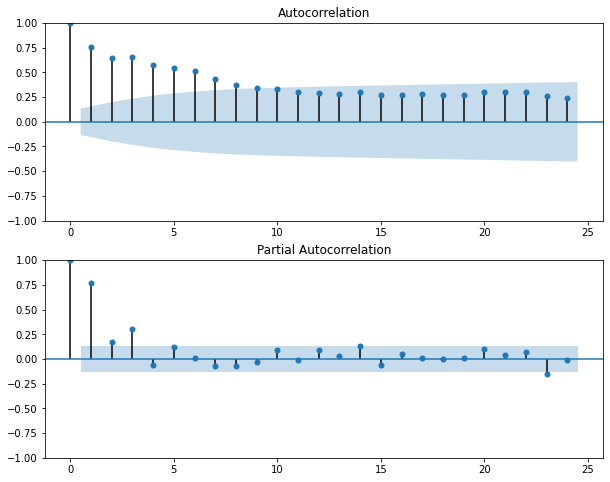

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10,8))
fig = sm.graphics.tsa.plot_acf(data, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data, ax=axes[1])

La fonction d'autocorrélation décroit progressivement vers $0$, ce qui signifie qu'on a un processus $MA(q)=0$. Nous pouvons sélectionner l'ordre $p$ du modèle $AR(p)$ en fonction des pics significatifs du tracé $PACF$. La fonction d'autocorrélation partielle nous indique que les trois premiers lag sont significatifs. Donc après analyse des $PACF$ et $ACF$ nous pouvons proposer un processus $AR(3)$ <br> <br>
Dans un deuxième temps nous allons utilisé les cirtères d'information $AIC$ et $BIC$ pour aider à sélectionné le $lag$

Nous calculons l'AIC et le BIC d'un AR(p) pour chaque valeur de p 

In [22]:
y = df['inflation'].dropna()

for i in [i for i in range(1,8)]:
    print("pour un p =",i)
    p = i
    q = 0
    mod = ARIMA(y, order=(p, 0, q)).fit()
    print('aic = ',mod.aic)
    print('bic = ',mod.bic)
    print("")

pour un p = 1
aic =  898.075459149992
bic =  908.1310335504202

pour un p = 2
aic =  893.8233211715016
bic =  907.2307537054058

pour un p = 3
aic =  876.3508753957205
bic =  893.1101660631009

pour un p = 4
aic =  877.5942586319991
bic =  897.7054074328555

pour un p = 5
aic =  876.582489128961
bic =  900.0454960632935

pour un p = 6
aic =  878.5733467681207
bic =  905.3882118359293

pour un p = 7
aic =  879.4074778227869
bic =  909.5742010240715



Les valeurs minimum pour nos critères d'informations $AIC$ et $BIC$ sont pour $p=3$. Ainsi au regard des résultats de nos crières on sélectionne un $lag = 3$. Nos deux méthodes nous revoies un $lag=3$. On va donc proposer pour notre série $inflation$ un modèle $AR(3)$.

### 9. Estimer le modèle de la courbe de Philips qui explique le taux de chômage (Unemp) en fonction du taux d’inflation courant et une constante. 


Exemple de courbe de Philips : 
- https://medium.datadriveninvestor.com/a-z-data-visualization-using-python-part-1-4d4337630a63
- http://www.bondeconomics.com/2019/05/underemployment-and-phillips-curve.html

In [23]:
X = pd.DataFrame(df['inflation'].dropna())
y = pd.DataFrame(df['Unemp'][1:])
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

# prédiction
y_pred = lr.predict(X)

Text(0.5, 0, 'Inflation')

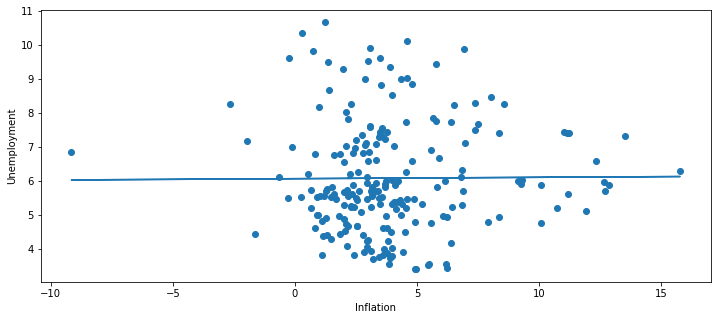

In [24]:
#Courbe de Philips
plt.figure(figsize=(12, 5))
plt.plot(df['inflation'].dropna(), y_pred)
plt.scatter(df['inflation'], df['Unemp'])
plt.ylabel('Unemployment')
plt.xlabel("Inflation")

In [25]:
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01214
Date:                Fri, 13 May 2022   Prob (F-statistic):              0.912
Time:                        11:38:41   Log-Likelihood:                -400.28
No. Observations:                 211   AIC:                             804.6
Df Residuals:                     209   BIC:                             811.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0708      0.181     33.576      0.000       5.714       6.427
inflation      0.0040      0.036      0.110      0.912      -0.067       0.075
==============================================================================
Omnibus:                       13.872   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.356
Skew:                           0.660   Prob(JB):                     0.000463
Kurtosis:                       2.937   Cond. No.                         8.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On note que le model n'a pas les résultats attendu ; effectivement l'estimateur du coéfficient directeur de notre de regression linéaire simple est positif ($0.0040$) alors qu'il est supposé être négatif. La courbe de Phillips est censé décrit une relation négative entre le taux de chômage et le taux d’inflation. Sur notre model l'inflation provoque une hausse du taux de chômage. 

sachant : La valeur p pour chaque terme teste l’hypothèse nulle que le coefficient est égal à zéro (aucun effet). Une faible valeur p (<0,05) nous indique que nous pouvons rejeter l’hypothèse nulle. En d’autres termes, un prédicteur qui a une faible valeur p est susceptible d’être un ajout significatif à notre modèle parce que les changements dans la valeur du prédicteur sont liés à des changements dans la variable de réponse. Inversement, une valeur p plus importante (non significative) suggère que les changements dans le prédicteur ne sont pas associés à des changements dans la réponse.

Au regard de la p-valeur du coéfficient associé à l'inflation $0.912 > 0.05$ ; en réalisé pour notre model il n'existe pas de relation entre le taux d'inflation et taux de chômage.

sources :
- https://blog.minitab.com/fr/comment-interpreter-les-resultats-de-lanalyse-de-regression-valeurs-p-et-coefficients#:~:text=La%20valeur%20p%20pour%20chaque,pouvez%20rejeter%20l'hypoth%C3%A8se%20nulle.
- https://partageonsleco.com/2020/02/05/la-courbe-de-phillips-fiche-concept/

### 10. Tester l’autocorrélation des erreurs. 

- https://www.xlstat.com/fr/solutions/fonctionnalites/durbin-watson-test
- https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic

In [26]:
erreurs = y - y_pred

X = df['DATE'].tolist()[:-1]

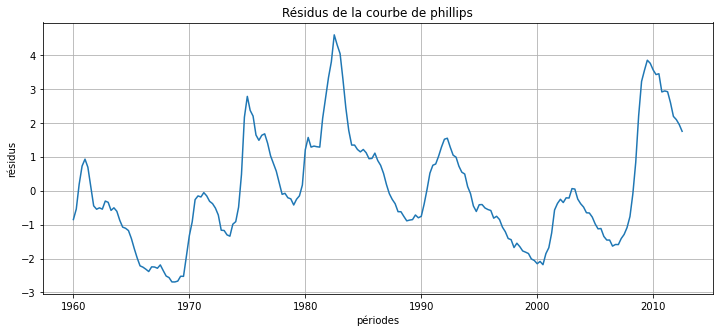

In [27]:
plt.figure(figsize=(12, 5))
plt.grid()
plt.ylabel('résidus')
plt.xlabel("périodes")
plt.title("Résidus de la courbe de phillips");
plt.plot(X, erreurs)

**Faisons un test d'autocorrélation avec la statistique de Durbin-Watson.**<br>
Le test de Durbin-Watson est un test statistique destiné à tester l'autocorrélation des résidus dans un modèle de régression linéaire. <br>

Le test de Durbin-Watson cherche à vérifier la significativité du coefficient $\rho$ dans la formule :

$\epsilon_t = \rho\epsilon_{t-1} + u_t$

où $\epsilon_t$ est le résidu estimé du modèle et $u_t$ est un bruit blanc

L'hypothèse nulle ($H_0$) stipule qu'il y a non auto-corrélation donc $\rho = 0$. L'hypothèse alternative ($H1$) stipule qu'il y a auto-corrélation (Les résidus sont distribués selon un $AR(1)$) donc $\rho$ est différent de 0 avec toujours $|\rho| < 1$.

In [28]:
print("la statistique de test de Durbin-Watson vaut",durbin_watson(erreurs))

la statistique de test de Durbin-Watson vaut [0.04419413]


Pour tester l'autocorrélation positive à la signification $\alpha$ , la statistique de test $d$ est <br> comparée aux valeurs critiques inférieure et supérieure ($d_{L,\alpha}$ et $d_{U,\alpha}$):

- Si $d<d_{L,\alpha}$ , il existe une preuve statistique que les termes d'erreur sont positivement autocorrélés et on rejette l’hypothèse nulle.
- Si $d>d_{U,\alpha}$ , il n'y a aucune preuve statistique que les termes d'erreur sont positivement autocorrélés et on ne rejette pas l’hypothèse nulle.
- Si $d_{L,\alpha}<d <d_{U,\alpha}$ , le test n'est pas concluant.

Pour tester l'autocorrélation négative à la signification $\alpha$ , la statistique de test $(4 −d)$ est <br> comparée aux valeurs critiques inférieure et supérieure ($d_{L,\alpha}$ et $d_{U,\alpha}$):

- Si $(4−d)<d_{L,\alpha}$ , il existe une preuve statistique que les termes d'erreur sont autocorrélés négativement et on rejette l’hypothèse nulle.
- Si $(4−d)>d_{U,\alpha}$ , il n'y a aucune preuve statistique que les termes d'erreur sont négativement autocorrélés et on ne rejette pas l’hypothèse nulle.
- Si $d_{L,\alpha}<(4−d)<d_{U,\alpha}$ , le test n'est pas concluant.

**Table de Dubin Watson**
- http://gwenn.parent.free.fr/documents/dw.pdf

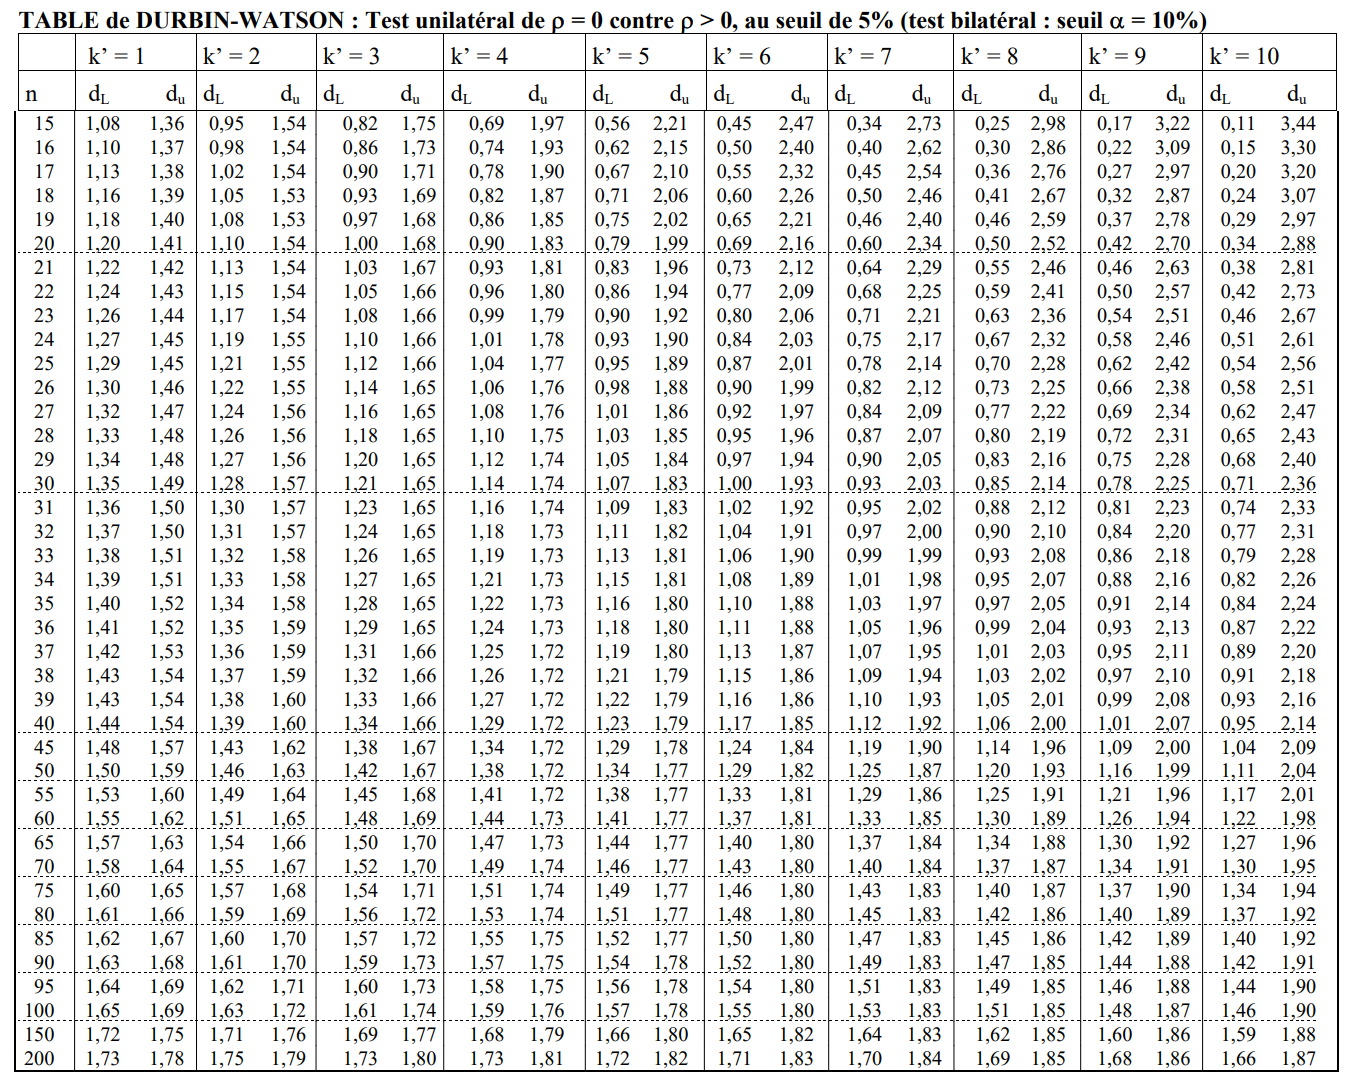

Pour un seuil $\alpha = 0.05$, un $k=2$ et un nombre d'observation $n\approx200$ les valeurs critiques inférieure et supérieure sont : 
- $d_{L,\alpha}=1.75$
- $d_{U,\alpha}=1.79$

Pour tester l'autocorrélation positive à la signification $\alpha=0.05$ , la statistique de test $d = 0.044$ est <br> comparée aux valeurs critiques inférieure et supérieure $d_{L,\alpha}=1.75$ et $d_{U,\alpha}=1.79$: <br>
nous obtenons :
- $(4−d)>d_{U,\alpha}$ , il n'y a aucune preuve statistique que les termes d'erreur sont négativement autocorrélés.
- $ d<d_{L,\alpha} $ il existe donc une preuve statistique que les termes d'erreur sont positivement autocorrélés

### 11. Corriger l’autocorrélation des erreurs par la méthode vue en cours. 

https://www.statsmodels.org/dev/examples/notebooks/generated/gls.html

http://risques-environnement.universite-lyon.fr/IMG/pdf/ectx_ii_l3_ch4_2015-16.pdf

Pour corriger l'autocorrélation des erreurs nous utiliserons la méthode des moindes carrées généralisable faible

In [29]:
X = pd.DataFrame(df['inflation'].dropna())
y = pd.DataFrame(df['Unemp'][1:])

X = sm.add_constant(X)

Nous calculons d'abord les résidus d'un OLS

In [30]:
ols_resid = sm.OLS(y, X).fit().resid

Supposons que les termes d'erreur suivent un processus AR(1) avec une tendance : <br>
$\epsilon_i=\beta_0+\rho\epsilon_{i-1}+\eta_i$ où $\eta\sim\mathcal{N}(0,\Sigma^2)$ <br>
$\rho$ est simplement la corrélation des résidu ; un estimateur cohérent de $\rho$ consiste à régresser les résidus sur les résidus décalés

In [31]:
resid_fit = sm.OLS(np.asarray(ols_resid)[1:], sm.add_constant(np.asarray(ols_resid)[:-1])).fit()
rho = resid_fit.params[1]

Comme nous le savons, un processus $AR(1)$ signifie que les plus proches voisins ont une relation plus forte. Nous pouvons donc donner cette structure en utilisant une matrice toeplitz.

In [32]:
order = toeplitz(range(len(ols_resid)))

de sorte que notre structure de covariance des erreurs est en fait $rho\times order$ qui définit une structure d'autocorrélation

In [33]:
sigma = rho ** order

Regardons les résultats de notre model $GLS$

In [34]:
gls_model = sm.GLS(y, X, sigma=sigma)
gls_results = gls_model.fit()
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  Unemp   R-squared:                       0.024
Model:                            GLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.186
Date:                Fri, 13 May 2022   Prob (F-statistic):             0.0238
Time:                        11:38:41   Log-Likelihood:                -68.505
No. Observations:                 211   AIC:                             141.0
Df Residuals:                     209   BIC:                             147.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3115      0.949      6.652      0.000       4.441       8.182
inflation     -0.0248      0.011     -2.277      0.024      -0.046      -0.003
==============================================================================
Omnibus:                       64.399   Durbin-Watson:                   0.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.061
Skew:                          -1.258   Prob(JB):                     3.61e-44
Kurtosis:                       7.053   Cond. No.                         87.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Première remarque :** le coéfficient de la variable $inflation$ est de signe négatif $-0.0248$; cette fois-ci cela correspond bien à la théorie de la courbe de Philips. **Une seconde remarque :** le coéfficient $inflation$ est devenu significatif avec une $p-valeur = 0.024 < 0.05$ ; on rejet donc l'hypothèse nulle (le coefficient est égal à zéro ; le coéfficient n'a aucun effet) au seuil $5\%$.

### 12. Tester la stabilité de la relation chômage-inflation sur deux sous-périodes de taille identique. 

- https://eric.univ-lyon2.fr/~ricco/cours/slides/Reg_Multiple_Test_de_Chow.pdf
- https://fr.wikipedia.org/wiki/Test_de_Chow
- https://econometrie.pagesperso-orange.fr/Chapitre%203/Test%20de%20CHOW.pdf

Nous souhaitons tester la stabilité de notre relation chômage inflation sur deux sous périodes identique. Pour cela nous procédons à un test de chow, nous allons partager notre jeu de données en deux sous-échantillon de taille identique. Notre premier échantillon va de 1960-04-01 à 1986-04-01 et le deuxième échantillon va de 1960-07-01 à 1012-10-01. Regardons les régressions suivantes : <br>
Soit le modèle initial : <br>
$y_t = a + bx_{1t} + \epsilon$ <br>
Nous séparons en deux groupes notre modèles, on a: <br>
$Model\space n°1 : y_t = a_1 + b_{1}x_{1t} + \epsilon$<br>
et <br>
$Model\space n°2 : y_t = a_2 + b_{2}x_{1t} + \epsilon$<br>
Le test de Chow revient à faire un test de Fisher sur l'hypothèse nulle : $H_{0} : a_1=a_2, b_1=b_2$ <br> <br>
Calculons la statistique du test de Chow : <br>
$F=\frac{SSR-(SSR_1+SSR_2)/ddl_n}{(SSR_1+SSR_2)/ddl_d}$

In [35]:
X = pd.DataFrame(df['inflation'].dropna())
y = pd.DataFrame(df['Unemp'][1:])

In [36]:
df1 = df[['DATE', 'Unemp', 'inflation']].dropna().reset_index(drop=True).iloc[:105,:].reset_index(drop=True)

df2 = df[['DATE', 'Unemp', 'inflation']].dropna().reset_index(drop=True).iloc[105:,:].reset_index(drop=True)

Calcul de la somme des carrés des résidus du model initial : $SSR$ 

In [37]:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

ssr = model.ssr

Calcul de la somme des carrés des résidus du model 1 : $SSR_1$ 

In [38]:
X1 = df1[['inflation']] ; X1 = sm.add_constant(X1) ; y1 = df1[['Unemp']]

model1 = sm.OLS(y1, X1).fit()

ssr1 = model1.ssr

Calcul de la somme des carrés des résidus du model 2 : $SSR_2$ 

In [39]:
X2 = df2[['inflation']] ; X2 = sm.add_constant(X2) ; y2 = df2[['Unemp']]

model2 = sm.OLS(y2, X2).fit()

ssr2 = model2.ssr

Calcul de la statistique de test : 

In [40]:
ddld = df.shape[0] - 2*(1+1)
ddln = 1 + 1
F = ( (ssr - (ssr1+ssr2))/ddln ) / ( (ssr1+ssr2)/ddld )

Calcul de la p-valeur

In [41]:
p_val = stats.f.sf(F,ddln, ddld) ; print("La p-valeur vaut",p_val)

La p-valeur vaut 0.14467378426000327


La p-valeur = 0.14 > 0.05 ; nous ne rejetons pas l'hypothèse nulle d'égalité de nos coéfficients sur les deux périodes. Sur deux sous-périodes de taille identique, il y a stabilité de la relation chômage inflation

### 13. Estimer la courbe de Philips en supprimant l'inflation courante des variables explicatives mais en ajoutant les délais d’ordre 1, 2, 3 et 4 de l’inflation et du chômage. Faire le test de Granger de non causalité de l’inflation sur le chômage. Donnez la p-valeur. 


- https://www.statology.org/granger-causality-test-in-python/

Nous calculons le modèle suivant maintenant : <br>
$unemp_i = constante + \beta_1inf_{i-1}+\beta_2inf_{i-2}+\beta_3inf_{i-3}+\beta_4inf_{i-4}$<br>
$+\gamma_1unemp_{i-1}+\gamma_2unemp_{i-2}+\gamma_3unemp_{i-3}+\gamma_4unemp_{i-4} + \epsilon_i$

Faisons le test de causalité de granger de l'inflation sur le chômage. On test l'hypothèse $H_0 = \beta_1=\beta_2=\beta_3=\beta_4=0$ . Voici les résultats que nous obtenon ci-dessous :

In [42]:
from statsmodels.tsa.stattools import grangercausalitytests

df = df.dropna()

grangercausalitytests(df[['Unemp', 'inflation']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7967  , p=0.0054  , df_denom=198, df_num=4
ssr based chi2 test:   chi2=15.8771 , p=0.0032  , df=4
likelihood ratio test: chi2=15.2977 , p=0.0041  , df=4
parameter F test:         F=3.7967  , p=0.0054  , df_denom=198, df_num=4


{4: ({'ssr_ftest': (3.796699198205299, 0.005351957807937344, 198.0, 4),
   'ssr_chi2test': (15.87710573794943, 0.0031885813965494892, 4),
   'lrtest': (15.297658304658398, 0.004122047806633439, 4),
   'params_ftest': (3.7966991982053133, 0.005351957807937242, 198.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

Au regard de la p-valeur qui est de $0.0054 < 0.05$ nous rejetons l'hypothèse nulle d'absence de causalité de Granger de l'inflation sur le chômage.

### 14. Représentez graphiquement les délais distribués et commentez. Calculer l’impact à long de terme de l’inflation sur le chômage. 

In [43]:
ds = df[['Unemp', 'inflation']].copy()

Unemp = df['Unemp'][4:]

inf_1 = df['inflation'][3:-1]
inf_2 = df['inflation'][2:-2]
inf_3 = df['inflation'][1:-3]
inf_4 = df['inflation'][:-4]

Unemp_1 = df['Unemp'][3:-1]
Unemp_2 = df['Unemp'][2:-2]
Unemp_3 = df['Unemp'][1:-3]
Unemp_4 = df['Unemp'][:-4]

ds = np.column_stack((Unemp, inf_1, inf_2, inf_3, inf_4, Unemp_1, Unemp_2, Unemp_3, Unemp_4))

ds = pd.DataFrame(ds)

ds.rename(columns={0:"Unemp", 1:"inf_1", 2:"inf_2", 3:"inf_3", 4:"inf_4", 5:"Unemp_1", 6:"Unemp_2", 7:"Unemp_3", 8:"Unemp_4"}, inplace=True)

ds

,Unemp,inf_1,inf_2,inf_3,inf_4,Unemp_1,Unemp_2,Unemp_3,Unemp_4
0,7.00,0.805910,2.568435,0.270544,2.312925,6.80,6.27,5.53,5.23
1,6.77,-0.134048,0.805910,2.568435,0.270544,7.00,6.80,6.27,5.53
2,6.20,1.609118,-0.134048,0.805910,2.568435,6.77,7.00,6.80,6.27
3,5.63,0.534224,1.609118,-0.134048,0.805910,6.20,6.77,7.00,6.80
4,5.53,1.600534,0.534224,1.609118,-0.134048,5.63,6.20,6.77,7.00
...,...,...,...,...,...,...,...,...,...
202,8.67,2.867703,4.575958,4.352577,2.990689,9.00,9.03,9.00,9.53
203,8.27,1.397117,2.867703,4.575958,4.352577,8.67,9.00,9.03,9.00
204,8.17,2.291052,1.397117,2.867703,4.575958,8.27,8.67,9.00,9.03
205,8.03,0.998817,2.291052,1.397117,2.867703,8.17,8.27,8.67,9.00


In [44]:
X = ds.iloc[:,1:]
y = ds.iloc[:,:1]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Unemp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1145.
Date:                Fri, 13 May 2022   Prob (F-statistic):          2.80e-161
Time:                        11:38:42   Log-Likelihood:                 4.6497
No. Observations:                 207   AIC:                             8.701
Df Residuals:                     198   BIC:                             38.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1457      0.072      2.014      0.045       0.003       0.288
inf_1          0.0078      0.009      0.827      0.409      -0.011       0.026
inf_2         -0.0059      0.010     -0.577      0.565      -0.026       0.014
inf_3          0.0172      0.010      1.729      0.085      -0.002       0.037
inf_4          0.0041      0.009      0.435      0.664      -0.014       0.023
Unemp_1        1.5937      0.071     22.383      0.000       1.453       1.734
Unemp_2       -0.6472      0.134     -4.832      0.000      -0.911      -0.383
Unemp_3        0.0222      0.135      0.164      0.870      -0.245       0.289
Unemp_4       -0.0080      0.070     -0.114      0.910      -0.146       0.130
==============================================================================
Omnibus:                       29.127   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.886
Skew:                           0.625   Prob(JB):                     1.10e-15
Kurtosis:                       5.534   Cond. No.                         170.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

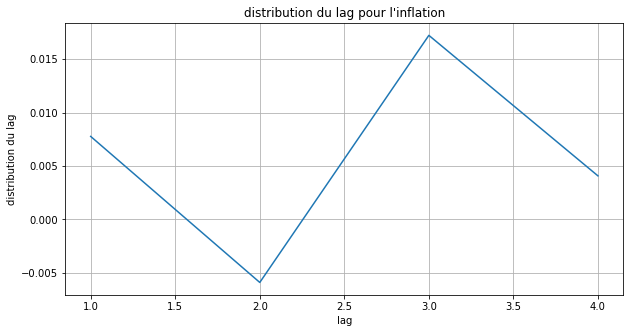

In [45]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.ylabel('distribution du lag')
plt.xlabel("lag")
plt.title("distribution du lag pour l'inflation");
plt.plot([i for i in range(1,5)], results.params[1:5].tolist())

In [46]:
sum(results.params[1:5].tolist())

0.023201419774779797

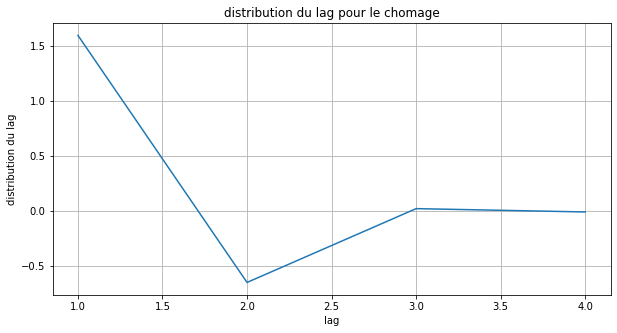

In [47]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.ylabel('distribution du lag')
plt.xlabel("lag")
plt.title("distribution du lag pour le chomage");
plt.plot([i for i in range(1,5)], results.params[5:].tolist())

Sur les résultats du graphique du retard distribué pour le chômage nous pouvons observer que le chômage peut s’expliquer par un passé très proche. Il y a une variabilité plus importante qui se produit après une crise ; puis nous observons des valeurs négative pendant deux périodes et enfin les valeurs se stabilise. Les valeurs fortement négatives dans la seconde période peuvent s’expliquer comme une compensation après une forte baisse du niveau d’emploi. <br> <br>
Sur les résultats du graphique du retard distribué pour l’inflation nous pouvons observer des résultats assez différents comparé au retard distribué pour le chômage. Il y a tout d’abord un faible effet positif sur l’inflation suivi d’un faible effet négatif ; la variation la plus importante se trouve sur la troisième période. Dans cette situation l’effet d’un choc met plus de temps à être retranscrit dans l’économie. <br> <br>
Nous pouvons calculer l’impact à long terme de l’inflation sur le chômage en faisant la somme des coefficients de l’inflation que nous avons calculer à l’aide de notre régression linéaire multiple : 
L’impacte à long terme de l’inflation sur le chômage est de 0.023 <br> <br>
Nous pouvons interpréter ce résultat comme étant : chaque unité d’inflation va entraîner une hausse de 0.023 unité (points) de chômage en plus à long terme.  